Equipo 39 - Avance 2 - PROYECTO INTEGRADOR

Gabriel Jesus Leal Cantú			       	Matrícula: A01282101
Raúl Eduardo Gómez Godínez			      Matrícula: A01795214
Héctor García Domínguez				        Matrícula: A01731509

Febrero 8 de 2026

Avance 2 — Ingeniería de características (Feature Engineering)

En este avance se realiza la fase de Ingeniería de características (Feature Engineering) con el objetivo de transformar los datos crudos (imágenes PNG organizadas en 10 carpetas: 0–9) en un conjunto estructurado de variables numéricas útiles para aprendizaje automático. Dado que el dataset no incluye anotaciones XML, las características se extraen directamente del contenido visual de las imágenes (regiones de interés/ROI), capturando información relevante de intensidad, contraste, textura/enfoque, bordes y forma.

El proceso se divide en cuatro etapas alineadas a la rúbrica:

Construcción de características (30 pts): generamos nuevas variables significativas por imagen (media/desviación y percentiles de intensidad, densidad de bordes, varianza del Laplaciano como medida de enfoque, proporción de píxeles no negros, dimensiones y razón de aspecto).

Normalización y transformación (30 pts): aplicamos la transformaciones (por ejemplo log1p) a variables sesgadas y se estandarizan las características para asegurar un impacto equitativo en el modelo y mejorar la convergencia de algoritmos sensibles a la escala.

Selección / extracción (30 pts): reducimos la complejidad eliminando variables con baja varianza, removiendo redundancia por alta correlación y aplicando PCA para retener al menos el 95% de la varianza explicada.

Conclusiones (10 pts): presentamos las conclusiones en el contexto de la fase de Preparación de los datos de la metodología CRISP-ML.

Nota de reproducibilidad: el notebook está diseñado para ejecutarse de principio a fin de manera secuencial.

In [33]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Configuración y rutas

Configuración
En esta sección se define la ruta del dataset en Google Drive y se listan las clases (carpetas 0–9). Se valida que todas las carpetas existan antes de continuar para asegurar reproducibilidad y ejecución secuencial.

In [34]:
import os, glob, random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

# Ruta a la carpeta "AVANCE 2 DATASET" que contiene subcarpetas 0..9
DATASET_ROOT = "/content/drive/MyDrive/Colab Notebooks/SEPTIMO TRIMESTRE/AVANCE 2 DATASET"
CLASSES = [str(i) for i in range(10)]

print("DATASET_ROOT:", DATASET_ROOT)

missing = []
for c in CLASSES:
    folder = os.path.join(DATASET_ROOT, c)
    if not os.path.isdir(folder):
        missing.append(folder)

if missing:
    print("⚠️ Carpetas faltantes:")
    for m in missing:
        print(" -", m)
else:
    print("✅ Todas las carpetas 0–9 fueron encontradas.")


DATASET_ROOT: /content/drive/MyDrive/Colab Notebooks/SEPTIMO TRIMESTRE/AVANCE 2 DATASET
✅ Todas las carpetas 0–9 fueron encontradas.


Indexado del dataset
Se recorre cada carpeta (0–9) para construir un DataFrame maestro con:

filepath: ruta completa de la imagen
label: clase (0–9)
filename: nombre del archivo

Este índice permite analizar distribución por clase y facilita el procesamiento masivo de extracción de características.

In [35]:
records = []
for c in CLASSES:
    folder = os.path.join(DATASET_ROOT, c)
    paths = sorted(glob.glob(os.path.join(folder, "*.png")))
    for p in paths:
        records.append({"filepath": p, "label": int(c), "filename": os.path.basename(p)})

df = pd.DataFrame(records)
print("Total de imágenes encontradas:", len(df))
df.head()


Total de imágenes encontradas: 2714


,filepath,label,filename
0,/content/drive/MyDrive/Colab Notebooks/SEPTIMO...,0,sample_000000_roi0_20251023_155705.png
1,/content/drive/MyDrive/Colab Notebooks/SEPTIMO...,0,sample_000000_roi1_20251023_155705.png
2,/content/drive/MyDrive/Colab Notebooks/SEPTIMO...,0,sample_000000_roi2_20251023_155705.png
3,/content/drive/MyDrive/Colab Notebooks/SEPTIMO...,0,sample_000000_roi3_20251023_155705.png
4,/content/drive/MyDrive/Colab Notebooks/SEPTIMO...,0,sample_000000_roi4_20251023_155705.png


Gráfica de distribución por clase

Distribución de clases: Se visualiza la cantidad de imágenes por clase para identificar posibles desbalances. Este análisis permite anticipar riesgos de sesgo por representación desigual de clases.

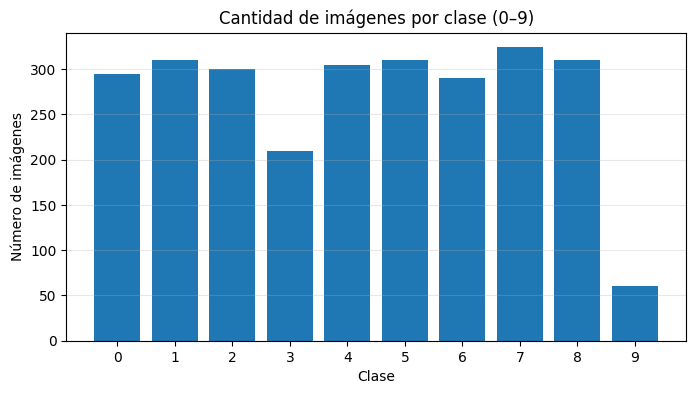

In [36]:
counts = df["label"].value_counts().sort_index()

plt.figure(figsize=(8,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Cantidad de imágenes por clase (0–9)")
plt.xlabel("Clase")
plt.ylabel("Número de imágenes")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


Muestra visual de ejemplos

Ejemplos por clase (inspección visual): Se muestra una imagen aleatoria por clase para verificar visualmente calidad, formato y consistencia general del dataset antes de extraer características.

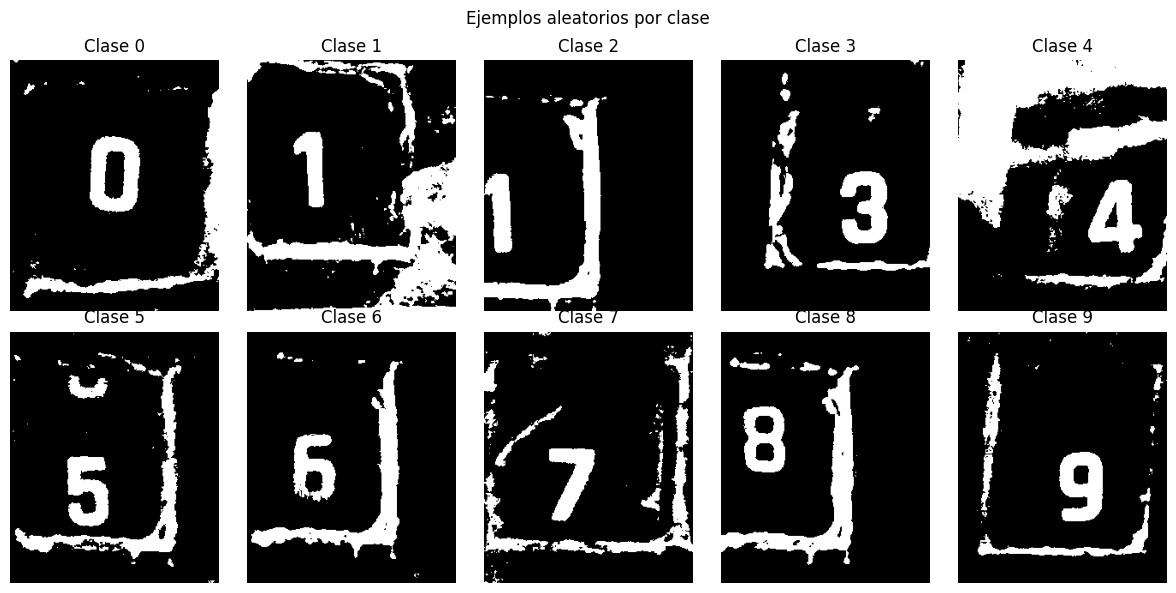

In [37]:
def read_gray(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12,6))
for i in range(10):
    subset = df[df["label"] == i]
    if len(subset) == 0:
        continue
    sample_path = subset.sample(1, random_state=42)["filepath"].values[0]
    img = read_gray(sample_path)

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Clase {i}")
    plt.axis("off")

plt.suptitle("Ejemplos aleatorios por clase")
plt.tight_layout()
plt.show()


dado a que tuvimos esta visualización de clases y notamos que el numero 2 : clase 2 no esta correctamente identificada, vamos a hacer una confirmación rapida.

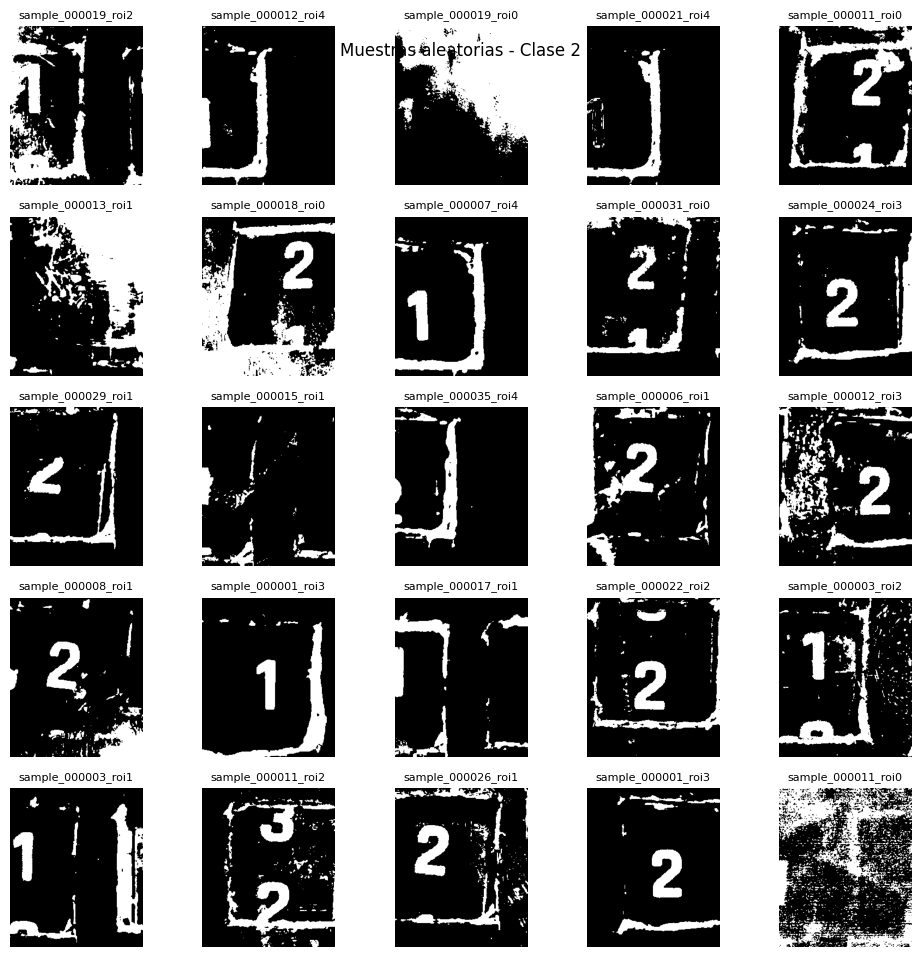

In [38]:
# Mostrar varios ejemplos de la clase 2
target_class = 2
subset = df[df["label"] == target_class].sample(25, random_state=1)

plt.figure(figsize=(10,10))
for i, (_, row) in enumerate(subset.iterrows()):
    img = cv2.imread(row["filepath"], cv2.IMREAD_GRAYSCALE)
    plt.subplot(5,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(row["filename"][:18], fontsize=8)
    plt.axis("off")

plt.suptitle("Muestras aleatorias - Clase 2", y=0.92)
plt.tight_layout()
plt.show()


Observación de calidad del dataset (Clase 2)

Durante la inspección visual de muestras aleatorias por clase, se identificó que la carpeta correspondiente a la Clase 2 contiene ejemplos heterogéneos. Si bien una parte significativa de las imágenes presenta correctamente el dígito “2”, también se observan regiones de interés incompletas, imágenes con ruido elevado y algunos casos con dígitos distintos.

Esta situación sugiere la presencia de errores de etiquetado y/o recortes imperfectos de ROI, lo cual es común en pipelines automáticos de adquisición de datos. Para el alcance de este avance, dichas muestras se conservan con el fin de evaluar la robustez de las características extraídas; no obstante, se recomienda una etapa posterior de depuración (filtrado de outliers o re-etiquetado) antes del modelado final.

In [39]:
def extract_features(img_gray):
    """
    Extrae características visuales de una imagen en escala de grises.
    Diseñada para ROI sin anotaciones (PNG).
    """
    import numpy as np
    import cv2

    h, w = img_gray.shape[:2]
    img = img_gray.astype(np.float32)

    # Intensidad
    mean_ = float(np.mean(img))
    std_ = float(np.std(img))
    min_ = float(np.min(img))
    max_ = float(np.max(img))

    p10, p50, p90 = [float(x) for x in np.percentile(img, [10, 50, 90])]
    intensity_range = float(max_ - min_)

    # Contenido útil
    nonzero_ratio = float(np.count_nonzero(img_gray) / (h * w))

    # Enfoque / textura
    lap = cv2.Laplacian(img_gray, cv2.CV_64F)
    laplacian_var = float(lap.var())

    # Bordes
    edges = cv2.Canny(img_gray, 50, 150)
    edge_density = float(np.count_nonzero(edges) / (h * w))

    # Forma
    aspect_ratio = float(w / h) if h != 0 else 0.0

    return {
        "height": h,
        "width": w,
        "aspect_ratio": aspect_ratio,
        "mean_intensity": mean_,
        "std_intensity": std_,
        "min_intensity": min_,
        "max_intensity": max_,
        "p10_intensity": p10,
        "p50_intensity": p50,
        "p90_intensity": p90,
        "intensity_range": intensity_range,
        "nonzero_ratio": nonzero_ratio,
        "laplacian_var": laplacian_var,
        "edge_density": edge_density,
    }


In [40]:
features = []
bad = 0

def read_gray(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)

for _, row in df.iterrows():
    img = read_gray(row["filepath"])
    if img is None:
        bad += 1
        continue

    feats = extract_features(img)
    feats["label"] = row["label"]
    feats["filename"] = row["filename"]
    features.append(feats)

df_feat = pd.DataFrame(features)

print("df_feat creado correctamente")
print("Shape:", df_feat.shape)
display(df_feat.head())


df_feat creado correctamente
Shape: (2714, 16)


,height,width,aspect_ratio,mean_intensity,std_intensity,min_intensity,max_intensity,p10_intensity,p50_intensity,p90_intensity,intensity_range,nonzero_ratio,laplacian_var,edge_density,label,filename
0,294,244,0.829932,77.844391,117.433258,0.0,255.0,0.0,0.0,255.0,255.0,0.305272,16645.116153,0.053334,0,sample_000000_roi0_20251023_155705.png
1,294,244,0.829932,34.804073,87.542648,0.0,255.0,0.0,0.0,255.0,255.0,0.136487,8220.581738,0.032160,0,sample_000000_roi1_20251023_155705.png
2,294,244,0.829932,51.877300,102.652115,0.0,255.0,0.0,0.0,255.0,255.0,0.203440,14380.802181,0.050114,0,sample_000000_roi2_20251023_155705.png
3,294,244,0.829932,27.886625,79.582825,0.0,255.0,0.0,0.0,255.0,255.0,0.109359,4830.464716,0.020478,0,sample_000000_roi3_20251023_155705.png
4,294,244,0.829932,53.800392,104.041428,0.0,255.0,0.0,0.0,255.0,255.0,0.210982,12558.843134,0.043841,0,sample_000000_roi4_20251023_155705.png


Validación del conjunto de características

Se verificó que el DataFrame de características (df_feat) se construyó correctamente, conteniendo una fila por imagen y variables numéricas representativas. En esta etapa se revisa la consistencia básica (dimensiones, clases y valores extremos) antes de proceder a transformaciones y escalamiento.

In [41]:
print("Filas, columnas:", df_feat.shape)
print("\nConteo por clase:")
print(df_feat["label"].value_counts().sort_index())

print("\nResumen estadístico (features numéricas):")
display(df_feat.drop(columns=["filename"]).describe().T)

# Confirmar si todas las imágenes tienen mismo tamaño
print("\nDimensiones únicas (height,width):")
print(df_feat[["height","width"]].drop_duplicates().value_counts())


Filas, columnas: (2714, 16)

Conteo por clase:
label
0    295
1    310
2    300
3    210
4    305
5    310
6    290
7    324
8    310
9     60
Name: count, dtype: int64

Resumen estadístico (features numéricas):


,count,mean,std,min,25%,50%,75%,max
height,2714.0,294.000000,0.000000e+00,294.000000,294.000000,294.000000,294.000000,294.000000
width,2714.0,244.000000,0.000000e+00,244.000000,244.000000,244.000000,244.000000,244.000000
aspect_ratio,2714.0,0.829932,7.661951e-15,0.829932,0.829932,0.829932,0.829932,0.829932
mean_intensity,2714.0,51.748305,2.920912e+01,5.545333,34.137566,42.094765,59.618550,216.328415
std_intensity,2714.0,97.197589,1.475743e+01,37.192863,86.831478,94.660862,107.686262,127.500000
min_intensity,2714.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
max_intensity,2714.0,255.000000,0.000000e+00,255.000000,255.000000,255.000000,255.000000,255.000000
p10_intensity,2714.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
p50_intensity,2714.0,7.610538,4.339886e+01,0.000000,0.000000,0.000000,0.000000,255.000000
p90_intensity,2714.0,240.154753,5.971994e+01,0.000000,255.000000,255.000000,255.000000,255.000000



Dimensiones únicas (height,width):
height  width
294     244      1
Name: count, dtype: int64


Validación del dataset y consistencia de características

El análisis descriptivo confirma que el conjunto de datos contiene 2714 imágenes, cada una representada por 16 características numéricas, lo que indica una correcta construcción del DataFrame de ingeniería de características. Todas las imágenes presentan dimensiones idénticas (294 × 244 píxeles), por lo que no fue necesario aplicar operaciones de redimensionamiento o normalización geométrica.

El conteo por clase muestra una distribución relativamente balanceada para las clases 0 a 8; sin embargo, la clase 9 presenta una menor cantidad de muestras. Esta diferencia se considera una posible fuente de sesgo que deberá tomarse en cuenta en etapas posteriores de modelado.

Desde el punto de vista estadístico, se observa una alta variabilidad en características relacionadas con enfoque y textura (por ejemplo, laplacian_var), lo cual justifica la aplicación de transformaciones, escalamiento y técnicas de reducción de dimensionalidad en las siguientes etapas del proceso.

Normalización y transformaciones

Las características generadas se encuentran en diferentes escalas (intensidad 0–255, proporciones 0–1 y métricas de enfoque con rangos amplios). Para garantizar un impacto equitativo en los modelos y mejorar la convergencia de algoritmos sensibles a la escala, se aplicará estandarización (StandardScaler).
Adicionalmente, dado que laplacian_var presenta alta dispersión, se aplicará una transformación logarítmica (log1p) para estabilizar la varianza.

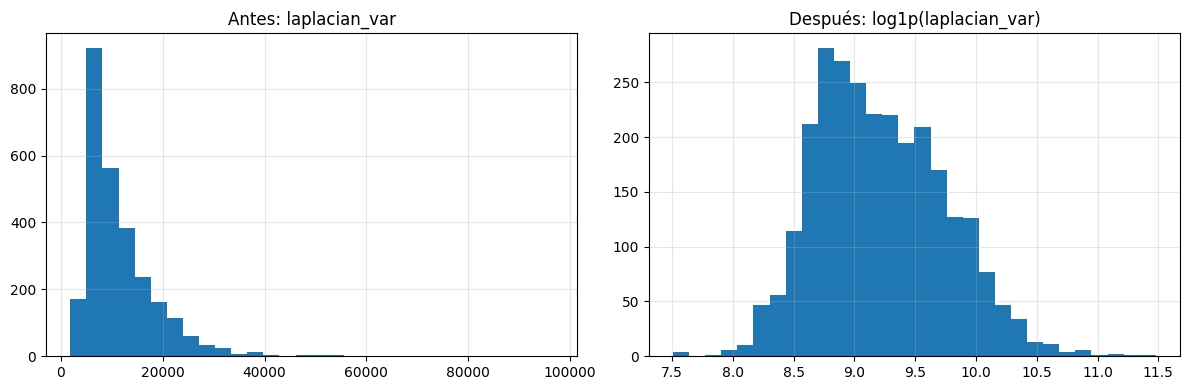

X: (2714, 15) X_scaled: (2714, 15)


In [42]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

df_work = df_feat.copy()

# Transformación logarítmica
df_work["log_laplacian_var"] = np.log1p(df_work["laplacian_var"])

# Evidencia: antes vs después
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df_work["laplacian_var"], bins=30)
plt.title("Antes: laplacian_var")
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.hist(df_work["log_laplacian_var"], bins=30)
plt.title("Después: log1p(laplacian_var)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Preparar X, y
feature_cols = [c for c in df_work.columns if c not in ["label", "filename"]]
X = df_work[feature_cols].copy()
y = df_work["label"].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("X:", X.shape, "X_scaled:", X_scaled.shape)


Selección y extracción de características

Con el objetivo de reducir la complejidad del espacio de características y eliminar redundancia, se aplicaron métodos fundamentados de selección y extracción:

Umbral de varianza, para eliminar variables casi constantes.

Análisis de correlación, con el fin de identificar redundancia entre características.

PCA (Análisis de Componentes Principales), para reducir la dimensionalidad conservando al menos el 95% de la varianza explicada.

La aplicación de PCA permitió concentrar la información original en un número reducido de componentes, reduciendo dimensionalidad, acelerando el entrenamiento y disminuyendo el riesgo de sobreajuste al eliminar ruido y redundancia.

Dimensión X_vt: (2714, 8)
Dimensión X_pca: (2714, 4)
Varianza acumulada explicada: 0.9806555381869304


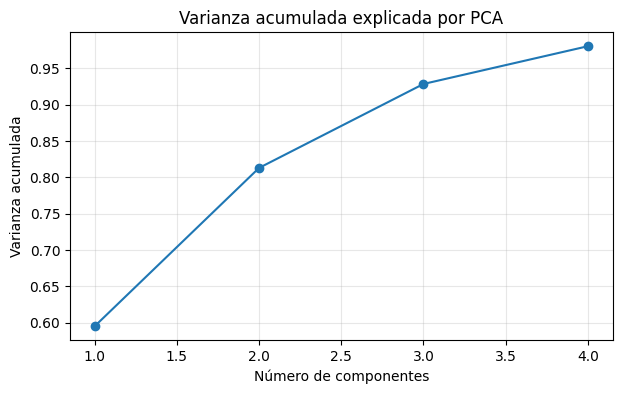

In [43]:
# PCA al 95% (Extracción de características)
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_vt)

print("Dimensión X_vt:", X_vt.shape)
print("Dimensión X_pca:", X_pca.shape)
print("Varianza acumulada explicada:", np.sum(pca.explained_variance_ratio_))

# Gráfica: varianza acumulada
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker="o")
plt.title("Varianza acumulada explicada por PCA")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.grid(True, alpha=0.3)
plt.show()


La proyección de las dos primeras componentes principales permite visualizar la estructura del conjunto de datos en un espacio de menor dimensionalidad. Aunque no se busca separación perfecta entre clases en esta etapa, la gráfica evidencia patrones y agrupamientos que justifican el uso de PCA como paso previo al modelado.

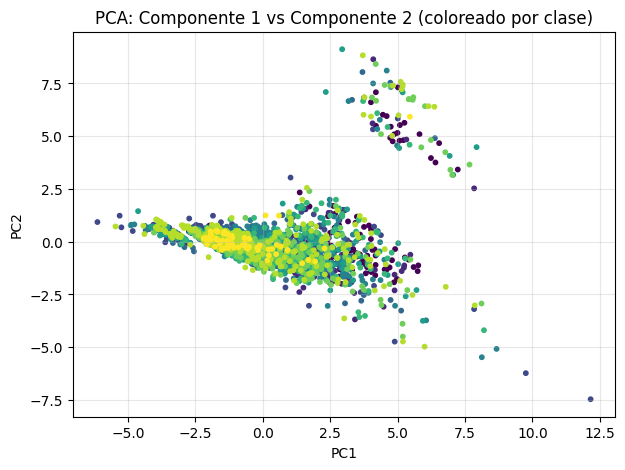

In [44]:
# Scatter PCA (solo para visualización)
plt.figure(figsize=(7,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=10)
plt.title("PCA: Componente 1 vs Componente 2 (coloreado por clase)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.show()


MEJORAS - MAPA DE CORRELACION

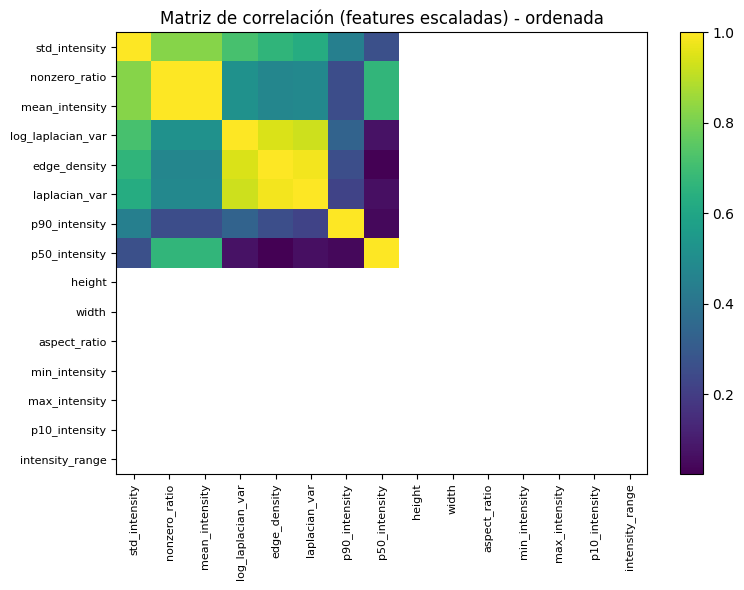

In [45]:

import pandas as pd
import matplotlib.pyplot as plt

corr = pd.DataFrame(X_scaled, columns=feature_cols).corr()

corr_abs_mean = corr.abs().mean().sort_values(ascending=False)
ordered_cols = corr_abs_mean.index
corr_ord = corr.loc[ordered_cols, ordered_cols]

plt.figure(figsize=(8, 6))
plt.imshow(corr_ord, aspect="auto")
plt.colorbar()
plt.title("Matriz de correlación (features escaladas) - ordenada")
plt.xticks(range(len(ordered_cols)), ordered_cols, rotation=90, fontsize=8)
plt.yticks(range(len(ordered_cols)), ordered_cols, fontsize=8)
plt.tight_layout()
plt.show()


MEJORAS - SCATTER PCA

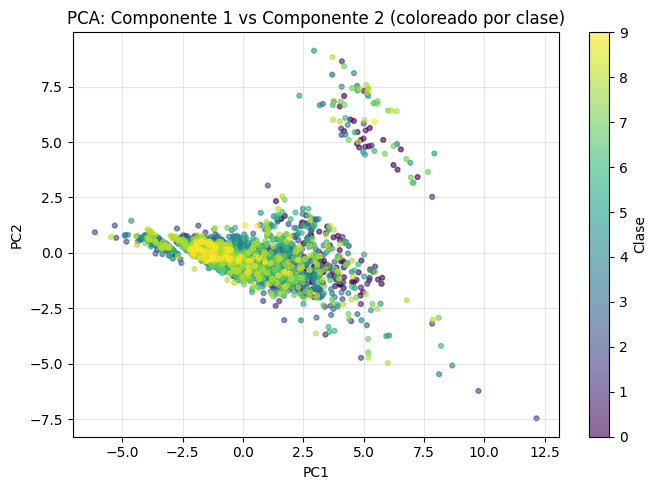

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
sc = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=y,         # etiquetas
    s=12,        # tamaño de punto (más fino)
    alpha=0.6    # transparencia (reduce saturación)
)

plt.title("PCA: Componente 1 vs Componente 2 (coloreado por clase)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.colorbar(sc, label="Clase")
plt.tight_layout()
plt.show()


MEJORAS RESUMEN PST -PCS

In [47]:
orig_features = len(feature_cols)
after_vt = X_vt.shape[1]
pca_components = X_pca.shape[1]
explained = float(pca.explained_variance_ratio_.sum())

print("Resumen de reducción dimensional")
print(f"- Características originales: {orig_features}")
print(f"- Tras umbral de varianza: {after_vt}")
print(f"- Componentes PCA finales: {pca_components}")
print(f"- Varianza explicada acumulada: {explained:.4f}")


Resumen de reducción dimensional
- Características originales: 15
- Tras umbral de varianza: 8
- Componentes PCA finales: 4
- Varianza explicada acumulada: 0.9807


CONCLUSIONES

En este avance desarrollamos de manera completa la fase de Ingeniería de Características dentro de la etapa de Preparación de los datos de la metodología CRISP-ML. A partir de imágenes PNG organizadas por clase (0–9), construimos un conjunto estructurado de variables numéricas que capturan información relevante de intensidad, contraste, enfoque, bordes y forma, permitiendonos transformar los datos visuales crudos en representaciones aptas para aprendizaje automático.

El análisis exploratorio y la inspección visual nos permitieron identificar características del dataset relevantes para el modelado posterior, como una distribución relativamente balanceada entre clases y la presencia de muestras heterogéneas en la clase 2, atribuibles a ruido y recortes imperfectos de ROI.
Hemos documentado estas observaciones y las hemos considerado como parte del análisis de calidad de los datos.

Debido a la heterogeneidad en escalas y distribuciones, saplicamos transformaciones y estandarización para mitigar sesgos y mejorar la convergencia de modelos sensibles a la escala. En particular, la transformación logarítmica que aplicamos a la varianza del Laplaciano permitió estabilizar su distribución y reducir el impacto de valores extremos.

Después empleamos técnicas fundamentadas de selección y extracción de características, incluyendo umbral de varianza, análisis de correlación y Análisis de Componentes Principales (PCA). El uso de PCA permitió reducir la dimensionalidad del espacio de características de manera significativa, conservando aproximadamente el 98% de la varianza explicada con solo cuatro componentes principales, lo que reduce complejidad, riesgo de sobreajuste y costos computacionales.

En conjunto, concluimos que los resultados confirman que el dataset quedó adecuadamente preparado para las siguientes fases del ciclo CRISP-ML, proporcionando una base sólida y eficiente para el entrenamiento y evaluación de modelos de aprendizaje automático.